In [1]:
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pyfftw
import os
import json
import time


%matplotlib inline

# Wrapper

Steps for using the wrapper:

* Load coordinates using Biopython
* Center and rotate the coordinates
* Save them as rcoord.txt, where r is x, y or z
* Create parameters file 
* Run the c++ code
* Load the projected image and the json with the cv and its gradient
* Enjoy

In [2]:
#First let's create some functions

def center_atomic_coord (x,y,z):
    
    x, y, z = x-np.mean(x), y-np.mean(y), z-np.mean(z)
    return(x, y, z) 

def quaternion_rotation(q, x, y, z):
    
    '''
    Performs a rotation using quaternions.
    
    If it is based from a quaternion q1 = w + xi + yj + zk, then the 
    quaternion array q should be q = [x, y, z, w]
    '''
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)
    

def read_grads():
    # Retrieve gradients of each training step fron the text output files
    # from the c++ program

    with open("../data/output/grad.json") as j_file:
        data = json.load(j_file)[0]
        s = data["s"]
        x_grad = np.array(data['sgrad_x']) 
        y_grad = np.array(data['sgrad_y'])
        z_grad = np.array(data['sgrad_z'])

        return s, np.array([x_grad, y_grad, z_grad])

1. Alinear con MDAnalaysis
2. Hacer el resto, pero con lo que da MDAnalaysis

In [6]:
%%capture
#Load data using Biopython

#Importat 1xck's PDB to extract XYZ atomic coordinates
parser = PDB.PDBParser()
io = PDB.PDBIO()
struct = parser.get_structure('1xck','../data/input/1xck.pdb')

x_atom=[]
y_atom=[]
z_atom=[]

for chains in struct:
    for chain in chains:
        for residue in chain:                             
            for atom in residue:

                x_atom.append(atom.get_vector()[0])
                y_atom.append(atom.get_vector()[1])
                z_atom.append(atom.get_vector()[2])

                
x_atom=np.array(x_atom)
y_atom=np.array(y_atom)
z_atom=np.array(z_atom)

In [7]:
x_atom.shape

(55301,)

In [8]:
#Quaternion parameters
'''
If it is based from a quaternion q1 = w + xi + yj + zk, then the 
quaternion array q should be q = [x, y, z, w]
'''

q=[0, 1/np.sqrt(2), 1/np.sqrt(2), 0]

#Center the coordinates
x_atom, y_atom, z_atom = center_atomic_coord (x_atom, y_atom, z_atom)

#Rotate them
x_atom, y_atom, z_atom = quaternion_rotation(q, x_atom, y_atom, z_atom)

#Save the coordinates
np.savetxt("../data/input/xcoord.txt", x_atom)
np.savetxt("../data/input/ycoord.txt", y_atom)
np.savetxt("../data/input/zcoord.txt", z_atom)

In [9]:
#Create the parameters file

n = 3; sigma = 1; res = 128

fout = open("../data/input/parameters.txt","w")
fout.write("""N = {n}
S = {s}
R = {r}
""".format(n=n, s=sigma, r=res))
fout.close()

#Defining pixel size
y = np.linspace(min(y_atom)-1,max(y_atom)+1, res)
x = np.linspace(min(x_atom)-1,max(x_atom)+1, res)

ps_y = y[1] - y[0]
ps_x = x[1] - x[0]

In [10]:
#run the c++ code

#uncomment if it is not compiled yet
#Arley since you're using windows I think you're going to have a few problems
#I'll try to make a makefile for you, but I have no way to test it

#os.system("cd .. && make");
start = time.time()
os.system("cd .. && ./main.out");
print("Projection time: {}".format(time.time() - start))

#archivos creados

#Ical.txt -> imagen proyectada
#grad.json -> un json con la cv y el grad

Projection time: 0.7971129417419434


In [12]:
#Load the projected image
Ixy_clean = np.loadtxt("../data/output/Iclean.txt")
Ixy_noise = np.loadtxt("../data/output/Inoise.txt")

#Load the json with the cv and its gradient
s, sgrad = read_grads()

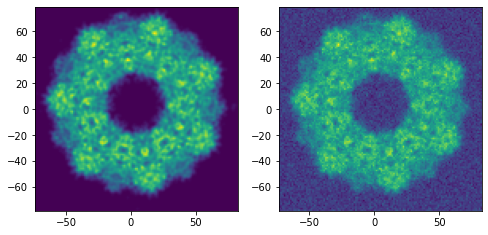

In [32]:
#Checking that everything worked
fig, ax = plt.subplots(1, 2, figsize=(8,5))

im1 = ax[0].imshow(Ixy_clean, extent=[x[0],x[-1],y[0],y[-1]], cmap="viridis")
im2 = ax[1].imshow(Ixy_noise, extent=[x[0],x[-1],y[0],y[-1]], cmap="viridis")

# CTF correction

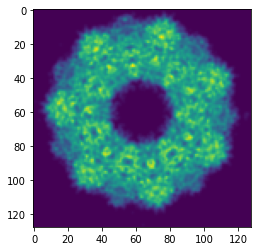

In [41]:
from scipy import signal

# First a 1-D  Gaussian
t = np.linspace(-10, 10, res)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1

# make a 2-D kernel out of it
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]

# mode='same' is there to enforce the same output shape as input arrays
# (ie avoid border effects)

kernel = kernel[:, :, np.newaxis]

img3 = signal.fftconvolve(Ixy_clean.reshape(128, 128, 1), kernel, mode='same')
plt.figure()
plt.imshow(Ixy_clean.reshape(128, 128, 1))

((70, 70), (768, 1024))

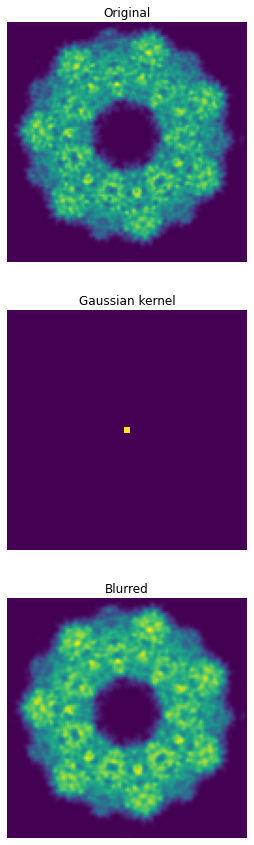

In [61]:
from scipy import misc

face = misc.face(gray=True)

kernel = np.outer(signal.windows.gaussian(70, 1/8),

                  signal.windows.gaussian(70, 1/8))

blurred = signal.fftconvolve(Ixy_clean, kernel, mode='same')


fig, (ax_orig, ax_kernel, ax_blurred) = plt.subplots(3, 1, figsize=(6, 15))

ax_orig.imshow(Ixy_clean, cmap='viridis')

ax_orig.set_title('Original')

ax_orig.set_axis_off()

ax_kernel.imshow(kernel, cmap='viridis')

ax_kernel.set_title('Gaussian kernel')

ax_kernel.set_axis_off()

ax_blurred.imshow(blurred, cmap='viridis')

ax_blurred.set_title('Blurred')

ax_blurred.set_axis_off()

kernel.shape, face.shape

# Now calculate the fourier transform of the projected image

Calculating the dfft takes 0.00021s 
python is not so bad after all


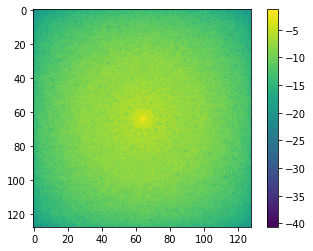

In [67]:
Ixy_f = np.fft.fftshift(np.fft.fft2(blurred))

start = time.time()
k = np.fft.fftshift(np.fft.fftfreq(res, ps_x))
print("Calculating the dfft takes {t:.2}s \npython is not so bad after all".format(t = time.time() - start))

plt.imshow(np.log(np.abs(Ixy_f)), cmap="viridis")
plt.colorbar();

Then we calculate the CTF defined as:

$$CTF(s; A, a, b) = \left[Acos\left(\frac{as^2}{2}\right) + \sqrt{1 - A^2} sin\left(\frac{as^2}{2}\right)\right] exp\left(\frac{bs^2}{2}\right)$$

Where the exponential corresponds to the envelop function and $A,\ a,\ b$ are parameters.

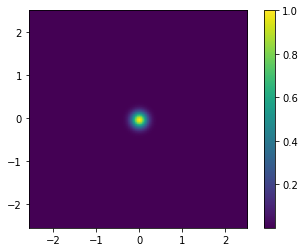

In [82]:
Env = lambda s, b_p: np.exp(-b_p * s * 0.5)
CTF = lambda s, A_p, a_p, b_p: (A_p*np.cos(a_p*s * 0.5) - np.sqrt(1 - A_p**2)*np.sin(a_p*s * 0.5)) * Env(s, b_p)


#Parameters for the CTF and Env; gaussian blurring
theta = 0#0.008
xi = 1/64#0.00375

A =  xi * 1/np.sqrt(xi**2 + theta**2)
a =  theta * 1/(theta**2 + xi**2)
b =  xi * 1/(theta**2 + xi**2)


'''
Define frequencies according to:

u = 2 * pi / (N * pixel_size) * i, with i = 0, ..., N-1

We are going to shift it so it's centered (just for visualization)
'''

u = 2*np.pi * np.arange(-res/2, res/2, 1) / (ps_x * res)
v = 2*np.pi * np.arange(-res/2, res/2, 1) / (ps_y * res)

pixels = res

ctf = np.zeros((u.shape[0], v.shape[0]))

for i in range(len(u)):
    for j in range(len(v)):
        
        radsq = u[i]**2 + v[j]**2
        val = CTF(radsq, A, a, b)
        
        if np.abs(val) < 1e-7: ctf[i, j] = 1e-7
            
        else: ctf[i, j] = val


plt.imshow(ctf, cmap='viridis', extent=[u[0],u[-1],v[0],v[-1]])
plt.colorbar()       

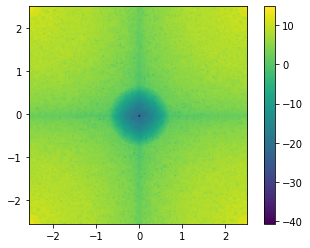

In [83]:
plt.imshow(np.log(np.abs(np.fft.fftshift(Ixy_f)/ctf)), cmap="viridis", extent=[u[0],u[-1],v[0],v[-1]])
plt.colorbar();

And lastly we calculate the inverse fourier transform to find the corrected image

$$I_{corr} = \mathcal{F}^{-1}\left\{ \frac{\mathcal{F}\{I\}}{CTF} \right\}$$

In [84]:
Icorr = np.fft.ifft2(Ixy_f/ctf)

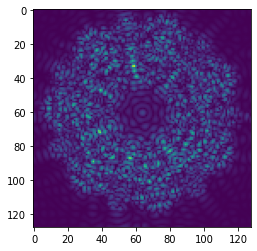

In [85]:
plt.imshow(np.abs(Icorr), cmap="viridis")